# Example of FedAvg and FedProx for two datasets: MNIST iid and MNIST non-iid



In [1]:
import torch

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from copy import deepcopy

import numpy as np

## 1. MNIST iid

In [2]:
"""UPLOADING THE DATASETS"""
import torchvision.datasets as datasets
import torchvision.transforms as transforms

mnist_trainset=datasets.MNIST(root='./data', train=True, download=True, 
    transform=transforms.ToTensor())
mnist_train_split = torch.utils.data.random_split(mnist_trainset, 
    [200, 200, 200, 60000 -3*200])[:-1]
mnist_train_dls =[torch.utils.data.DataLoader(ds, batch_size=10, 
    shuffle=True) for ds in mnist_train_split]

mnist_testset=datasets.MNIST(root='./data', train=False, download=True, 
    transform=transforms.ToTensor()) 
mnist_test_split = torch.utils.data.random_split(mnist_testset, 
    [100, 100, 100, 10000 -3*100])[:-1]
mnist_test_dls =[torch.utils.data.DataLoader(ds, batch_size=10, 
    shuffle=True) for ds in mnist_test_split]

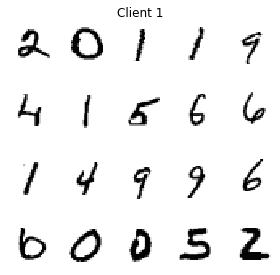

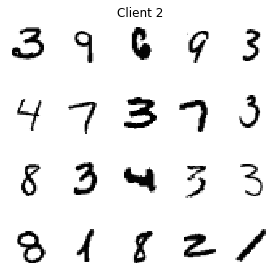

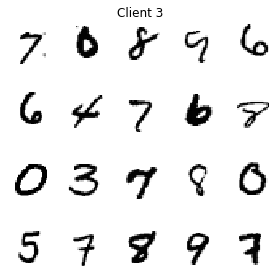

In [3]:
# In[2]: 
"""PLOT THE DISTRIBUTION OF A CLIENT"""
def plot_samples(dataset, title=None, plot_name="", n_examples=20):
    
    n_rows = abs(n_examples / 5)
    plt.figure(figsize=(1* n_rows, 1*n_rows))
    if title: plt.suptitle(title)
    
    for idx,(X,y) in enumerate(dataset.dataset):
        
        if idx<n_examples:
    
            ax = plt.subplot(n_rows, 5, idx + 1)
            #ax.set_title(f"{y}")
            
            image = 255 - X.view((28,28))
            ax.imshow(image, cmap='gist_gray')
            ax.axis("off")

    if plot_name!="":plt.savefig(f"plots/"+plot_name+".png")
        
    plt.tight_layout()
        
plot_samples(mnist_train_dls[0],"Client 1")
plot_samples(mnist_train_dls[1],"Client 2")
plot_samples(mnist_train_dls[2],"Client 3")

In [4]:
class NN(nn.Module):
    
    def __init__(self,layer_1,layer_2):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(784,layer_1)
        self.fc3 = nn.Linear(layer_1,10)

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1,784)))
        x=self.fc3(x)
        return x
    
model_0=NN(50,10)

In [5]:
def loss_classifier(predictions,labels):
    
    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss(reduction="mean")
    
    return loss(m(predictions) ,labels.view(-1))


def loss_dataset(model, train_data, loss_f):
    """Compute the loss of `model` on `test_data`"""
    loss=0
    
    for idx,(features,labels) in enumerate(train_data):
        
        predictions= model(features)
        loss+=loss_f(predictions,labels)
    
    loss/=idx+1
    return loss


def accuracy_dataset(model,dataset):
    """Compute the accuracy of `model` on `test_data`"""
    
    correct=0
    
    for features,labels in iter(dataset):
        
        predictions= model(features)
        
        _,predicted=predictions.max(1,keepdim=True)
        
        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()
        
    accuracy = 100*correct/len(dataset.dataset)
        
    return accuracy


def train_step(model, model_0, mu:int, optimizer, train_data, loss_f):
    """Train `model` on one epoch of `train_data`"""
    
    total_loss=0
    
    for idx, (features,labels) in enumerate(train_data):
        
        optimizer.zero_grad()
        
        predictions= model(features)
        
        loss=loss_f(predictions,labels)
        loss+=mu/2*difference_models_norm_2(model,model_0)
        total_loss+=loss
        
        loss.backward()
        optimizer.step()
        
    return total_loss/(idx+1)



def local_learning(model, mu:float, optimizer, train_data, epochs:int, loss_f):
    
    model_0=deepcopy(model)
    
    for e in range(epochs):
        local_loss=train_step(model,model_0,mu,optimizer,train_data,loss_f)
        
    return float(local_loss.detach().numpy())


def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """
    
    tensor_1=list(model_1.parameters())
    tensor_2=list(model_2.parameters())
    
    norm=sum([torch.sum((tensor_1[i]-tensor_2[i])**2) 
        for i in range(len(tensor_1))])
    
    return norm


def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)
        
        
def FedAvg_agregation_process(model, clients_models_hist:list , weights:list):
    """Creates the new model of a given iteration with the models of the other
    clients"""
    
    new_model=deepcopy(model)
    set_to_zero_model_weights(new_model)

    for k,client_hist in enumerate(clients_models_hist):
        
        for idx, layer_weights in enumerate(new_model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)
            
    return new_model



def FedProx(model, training_sets:list, n_iter:int, testing_sets:list, mu=0, 
    file_name="test", epochs=5, lr=10**-2, decay=1):
    """ all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the 
            training set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularixation term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration
    
    returns :
        - `model`: the final global model 
    """
        
    loss_f=loss_classifier
    
    #Variables initialization
    K=len(training_sets) #number of clients
    n_samples=sum([len(db.dataset) for db in training_sets])
    weights=([len(db.dataset)/n_samples for db in training_sets])
    print("Clients' weights:",weights)
    
    
    loss_hist=[[float(loss_dataset(model, dl, loss_f).detach()) 
        for dl in training_sets]]
    acc_hist=[[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist=[[tens_param.detach().numpy() 
        for tens_param in list(model.parameters())]]
    models_hist = []
    
    
    server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
    server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}')
    
    for i in range(n_iter):
        
        clients_params=[]
        clients_models=[]
        clients_losses=[]
        
        for k in range(K):
            
            local_model=deepcopy(model)
            local_optimizer=optim.SGD(local_model.parameters(),lr=lr)
            
            local_loss=local_learning(local_model,mu,local_optimizer,
                training_sets[k],epochs,loss_f)
            
            clients_losses.append(local_loss)
                
            #GET THE PARAMETER TENSORS OF THE MODEL
            list_params=list(local_model.parameters())
            list_params=[tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)    
            clients_models.append(deepcopy(local_model))
        
        
        #CREATE THE NEW GLOBAL MODEL
        model = FedAvg_agregation_process(deepcopy(model), clients_params, 
            weights=weights)
        models_hist.append(clients_models)
        
        #COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist+=[[float(loss_dataset(model, dl, loss_f).detach()) 
            for dl in training_sets]]
        acc_hist+=[[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
        server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])

        print(f'====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}')
        

        server_hist.append([tens_param.detach().cpu().numpy() 
            for tens_param in list(model.parameters())])
        
        #DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr*=decay
            
    return model, loss_hist, acc_hist

In [6]:
"""RUN FEDAVG""" 
n_iter=10

model_f, loss_hist_FA_iid, acc_hist_FA_iid = FedProx( model_0, 
    mnist_train_dls, n_iter, mnist_test_dls)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3152280648549395 Server Test Accuracy: 9.666666666666664
====> i: 1 Loss: 2.077920834223429 Server Test Accuracy: 32.33333333333333
====> i: 2 Loss: 1.7763458887736001 Server Test Accuracy: 46.666666666666664
====> i: 3 Loss: 1.451335589090983 Server Test Accuracy: 57.33333333333333
====> i: 4 Loss: 1.1880313158035278 Server Test Accuracy: 66.66666666666666
====> i: 5 Loss: 0.9950338204701741 Server Test Accuracy: 71.0
====> i: 6 Loss: 0.8533134261767068 Server Test Accuracy: 76.0
====> i: 7 Loss: 0.7462861935297647 Server Test Accuracy: 78.66666666666666
====> i: 8 Loss: 0.6632819771766663 Server Test Accuracy: 80.66666666666666
====> i: 9 Loss: 0.5970219771067301 Server Test Accuracy: 82.33333333333333
====> i: 10 Loss: 0.5427657763163248 Server Test Accuracy: 82.33333333333333


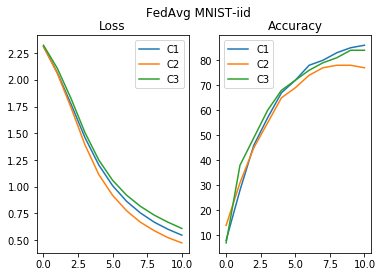

In [7]:
"""PLOT THE LOSS AND ACC HISTORY FOR THE DIFFERENT CLIENTS FOR FEDAVG"""

def plot_acc_loss(title:str, loss_hist:list, acc_hist:list):
    plt.figure()
    
    plt.suptitle(title)

    plt.subplot(1,2,1)
    lines=plt.plot(loss_hist)
    plt.title("Loss")
    plt.legend(lines,["C1", "C2", "C3"])

    plt.subplot(1,2,2)
    lines=plt.plot(acc_hist )
    plt.title("Accuracy")
    plt.legend(lines, ["C1", "C2", "C3"])
    

plot_acc_loss("FedAvg MNIST-iid", loss_hist_FA_iid, acc_hist_FA_iid)

In [8]:
"""RUN FEDPROx, mu=1""" 
n_iter=10

model_f, loss_hist_FP_iid, acc_hist_FP_iid = FedProx( model_0, mnist_train_dls, 
    n_iter, mnist_test_dls, mu =1.)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3152278264363604 Server Test Accuracy: 9.666666666666664
====> i: 1 Loss: 2.160791953404744 Server Test Accuracy: 21.666666666666664
====> i: 2 Loss: 1.9843504826227822 Server Test Accuracy: 39.33333333333333
====> i: 3 Loss: 1.7798415819803872 Server Test Accuracy: 46.33333333333333
====> i: 4 Loss: 1.5679299434026082 Server Test Accuracy: 54.0
====> i: 5 Loss: 1.3742664655049641 Server Test Accuracy: 60.0
====> i: 6 Loss: 1.2120484908421834 Server Test Accuracy: 65.0
====> i: 7 Loss: 1.0791771014531453 Server Test Accuracy: 69.0
====> i: 8 Loss: 0.9699301520983377 Server Test Accuracy: 72.33333333333333
====> i: 9 Loss: 0.8801418542861938 Server Test Accuracy: 74.33333333333333
====> i: 10 Loss: 0.804727832476298 Server Test Accuracy: 76.66666666666666


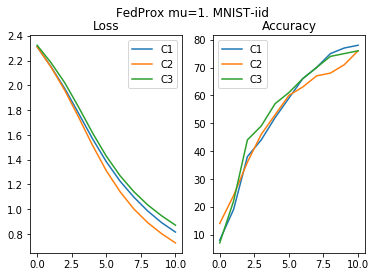

In [9]:
plot_acc_loss("FedProx mu=1. MNIST-iid", loss_hist_FP_iid, acc_hist_FP_iid)

## 2. MNIST non-iid

In [10]:
fonts = ['InconsolataN']#,'jsMath-cmti10']
all_digits=[i for i in range(10)]

C1= {
     'n_samples_train': 200,
     'font':'InconsolataN',
     'numbers': all_digits,
     'tilt':0,
     'std_tilt': 10, #std on the tilt,
     'seed':0
     }
C1['n_samples']= int(1.5 * C1['n_samples_train']) #20% more for the testing set



C2=deepcopy(C1)
C2['tilt'] = 45

C3=deepcopy(C1)
C3['tilt']=90

clients = [C1, C2, C3]

In [11]:
from create_custom_MNIST import MNIST_custom_train_test_sets
custom_mnist_train, custom_mnist_test = MNIST_custom_train_test_sets(clients)

0 %
3 %
7 %
10 %
13 %
17 %
20 %
23 %
27 %
30 %
33 %
37 %
40 %
43 %
47 %
50 %
53 %
57 %
60 %
63 %
67 %
70 %
73 %
77 %
80 %
83 %
87 %
90 %
93 %
97 %
0 %
3 %
7 %
10 %
13 %
17 %
20 %
23 %
27 %
30 %
33 %
37 %
40 %
43 %
47 %
50 %
53 %
57 %
60 %
63 %
67 %
70 %
73 %
77 %
80 %
83 %
87 %
90 %
93 %
97 %
0 %
3 %
7 %
10 %
13 %
17 %
20 %
23 %
27 %
30 %
33 %
37 %
40 %
43 %
47 %
50 %
53 %
57 %
60 %
63 %
67 %
70 %
73 %
77 %
80 %
83 %
87 %
90 %
93 %
97 %


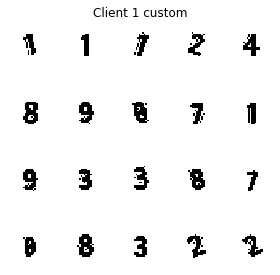

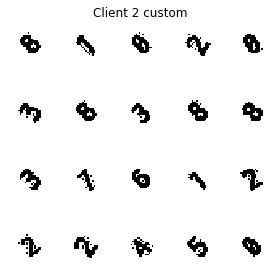

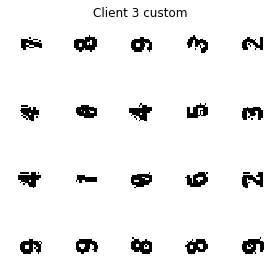

In [12]:
plot_samples(custom_mnist_train[0], "Client 1 custom")
plot_samples(custom_mnist_train[1], "Client 2 custom")
plot_samples(custom_mnist_train[2], "Client 3 custom")

In [13]:
class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model_0 = CNN()

In [ ]:
n_iter=10

model_f, loss_hist_FA_niid, acc_hist_FA_niid = FedProx( model_0, custom_mnist_train, 
    n_iter, custom_mnist_test, epochs=5, lr=0.1)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.304858684539795 Server Test Accuracy: 7.666666666666666
====> i: 1 Loss: 2.2495672702789307 Server Test Accuracy: 14.333333333333332
====> i: 2 Loss: 2.147202094395955 Server Test Accuracy: 17.0
====> i: 3 Loss: 1.8952369689941406 Server Test Accuracy: 36.666666666666664
====> i: 4 Loss: 1.6778336763381956 Server Test Accuracy: 33.33333333333333
====> i: 5 Loss: 1.3170110384623208 Server Test Accuracy: 58.99999999999999
====> i: 6 Loss: 0.9794035752614338 Server Test Accuracy: 62.0
====> i: 7 Loss: 0.7040616075197855 Server Test Accuracy: 73.0


In [ ]:
plot_acc_loss("FedProx MNIST non-iid", loss_hist_FA_niid, acc_hist_FA_niid)

In [ ]:
n_iter=10

model_f, loss_hist_FP_niid, acc_hist_FP_niid = FedProx( model_0, custom_mnist_train, 
    n_iter, custom_mnist_test, epochs=5, lr=0.1, mu=0.1)

In [ ]:
plot_acc_loss("FedProx mu=0.5 MNIST non-iid", loss_hist_FP_niid, acc_hist_FP_niid)